In [1]:
# Install CUDA-compatible dependencies
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
!pip install ultralytics yt-dlp opencv-python
!pip install matplotlib filterpy

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Unin

In [2]:
# Verify GPU availability
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

CUDA available: True
Device name: Tesla T4


In [22]:
# Replace VIDEO_URL with actual YouTube URL
!yt-dlp -f 'bestvideo[ext=mp4]' -o input_video.mp4 "https://www.youtube.com/shorts/MwxxofLNpTg"

[youtube] Extracting URL: https://www.youtube.com/shorts/MwxxofLNpTg
[youtube] MwxxofLNpTg: Downloading webpage
[youtube] MwxxofLNpTg: Downloading tv client config
[youtube] MwxxofLNpTg: Downloading player 6b3caec8
[youtube] MwxxofLNpTg: Downloading tv player API JSON
[youtube] MwxxofLNpTg: Downloading ios player API JSON
[youtube] MwxxofLNpTg: Downloading m3u8 information
[info] MwxxofLNpTg: Downloading 1 format(s): 609
[download] input_video.mp4 has already been downloaded
[download] 100% of    4.03MiB


Total frames extracted: 451

First processed frame:


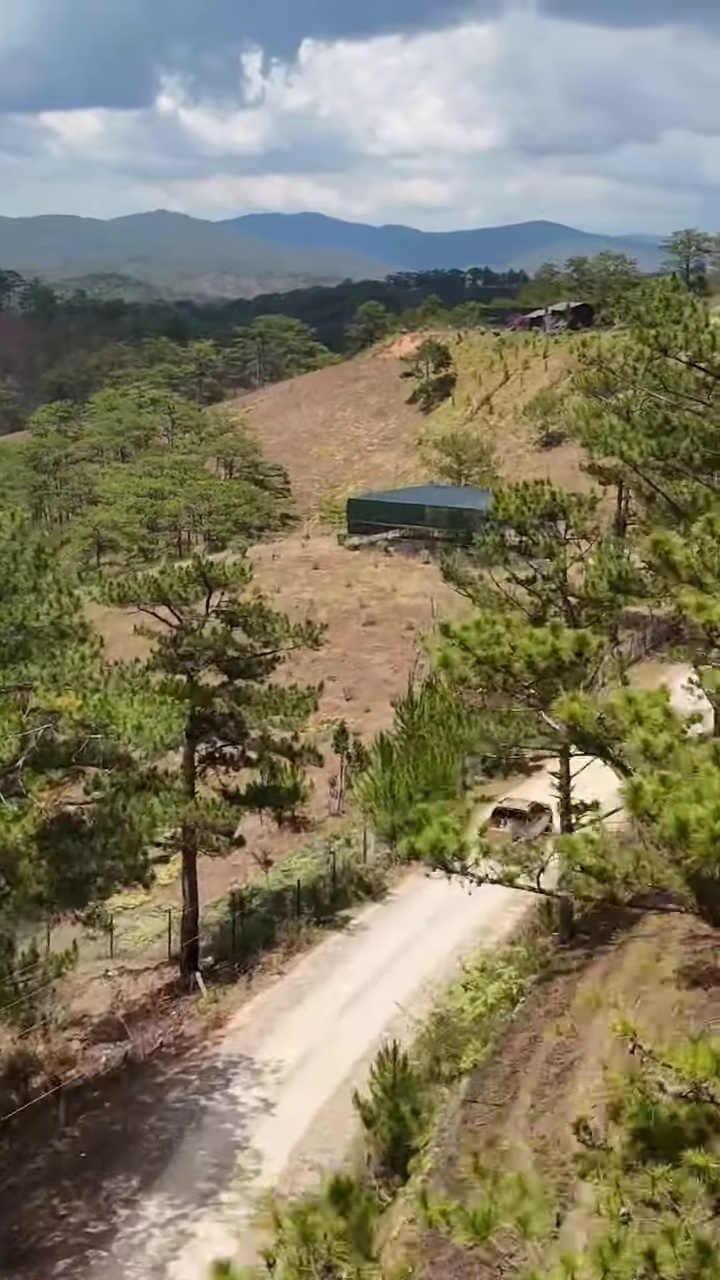

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
import cv2
import os
from ultralytics import YOLO
from google.colab.patches import cv2_imshow

# Create directories
!mkdir -p frames processed_frames

# Split video into frames
def video_to_frames(video_path, output_folder):
    cap = cv2.VideoCapture(video_path)
    count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        cv2.imwrite(f"{output_folder}/frame_{count:04d}.jpg", frame)
        count += 1

    cap.release()
    return count

# Convert video to frames
total_frames = video_to_frames('input_video.mp4', 'frames')
print(f"Total frames extracted: {total_frames}")

# Initialize YOLOv8 model with GPU acceleration
model = YOLO('yolov8l.pt').to('cuda')  # Move model to GPU
model.fp16 = True  # Enable mixed precision inference

# Process frames with GPU acceleration
for frame_name in sorted(os.listdir('frames')):
    frame_path = os.path.join('frames', frame_name)
    frame = cv2.imread(frame_path)

    # Detect objects using GPU
    results = model(frame,
                   device='cuda',
                   half=True,  # FP16 inference
                   verbose=False)

    # Draw annotations
    for result in results:
        for box in result.boxes:
            if model.names[int(box.cls)] == 'car':
                x1, y1, x2, y2 = map(int, box.xyxy.cpu().numpy()[0])

                # Draw bounding box
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

                # Calculate and draw centroid
                cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
                cv2.circle(frame, (cx, cy), 5, (0, 0, 255), -1)

    # Save processed frame
    output_path = os.path.join('processed_frames', frame_name)
    cv2.imwrite(output_path, frame)

# Create output video (same as before)
def frames_to_video(input_folder, output_path, fps):
    frame_names = sorted(os.listdir(input_folder))
    first_frame = cv2.imread(os.path.join(input_folder, frame_names[0]))
    h, w, _ = first_frame.shape

    writer = cv2.VideoWriter(output_path,
                           cv2.VideoWriter_fourcc(*'mp4v'),
                           fps,
                           (w, h))

    for frame_name in frame_names:
        frame = cv2.imread(os.path.join(input_folder, frame_name))
        writer.write(frame)

    writer.release()

# Get original video FPS
cap = cv2.VideoCapture('input_video.mp4')
original_fps = cap.get(cv2.CAP_PROP_FPS)
cap.release()

# Generate final video
frames_to_video('processed_frames', 'output_video.mp4', original_fps)

# Preview
print("\nFirst processed frame:")
cv2_imshow(cv2.imread(os.path.join('processed_frames', os.listdir('processed_frames')[0])))

# Download result
from google.colab import files
files.download('output_video.mp4')

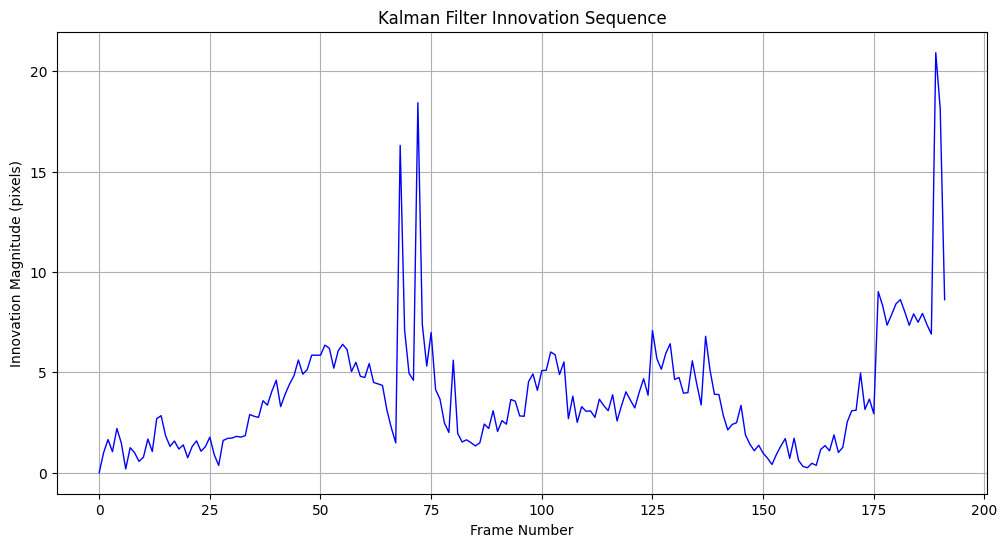

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
from ultralytics import YOLO
from google.colab.patches import cv2_imshow

# Initialize YOLOv8 model with GPU
model = YOLO('yolov8l.pt').to('cuda')
model.fp16 = True

# Video processing setup
cap = cv2.VideoCapture('input_video.mp4')
fps = cap.get(cv2.CAP_PROP_FPS)
dt = 1/fps

# Kalman Filter initialization
def create_kalman_filter(dt):
    kf = KalmanFilter(dim_x=4, dim_z=2)

    # State transition matrix (constant velocity model)
    kf.F = np.array([[1, 0, dt, 0],
                     [0, 1, 0, dt],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1]])

    # Measurement matrix
    kf.H = np.array([[1, 0, 0, 0],
                     [0, 1, 0, 0]])

    # Process noise covariance
    kf.Q = np.eye(4) * 0.1

    # Measurement noise covariance
    kf.R = np.eye(2) * 5

    # Initial state covariance
    kf.P = np.eye(4) * 1000

    return kf

kf = None
innovations = []
tracking_history = []

# Output video setup
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
output_video = cv2.VideoWriter('tracked_video.mp4',
                             cv2.VideoWriter_fourcc(*'mp4v'),
                             fps,
                             (frame_width, frame_height))

# Process frames
frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Detect cars using YOLOv8
    results = model(frame, device='cuda', half=True, verbose=False)
    car_detected = False
    current_measurement = None

    # Find largest car detection
    max_area = 0
    for result in results:
        for box in result.boxes:
            if model.names[int(box.cls)] == 'car':
                x1, y1, x2, y2 = map(int, box.xyxy.cpu().numpy()[0])
                area = (x2 - x1) * (y2 - y1)
                if area > max_area:
                    max_area = area
                    current_measurement = np.array([(x1+x2)//2, (y1+y2)//2])
                    car_detected = True

    # Kalman Filter processing
    if car_detected:
        if kf is None:
            # Initialize Kalman Filter
            kf = create_kalman_filter(dt)
            kf.x = np.array([current_measurement[0],
                           current_measurement[1],
                           0, 0])  # Initial state: [x, y, vx, vy]
            tracking_history.append(current_measurement)
        else:
            # Predict and update
            kf.predict()
            kf.update(current_measurement)

            # Calculate innovation
            innovation = current_measurement - kf.H @ kf.x_prior
            innovations.append(np.linalg.norm(innovation))

            tracking_history.append(kf.x[:2])
    elif kf is not None:
        # Predict only when no measurement
        kf.predict()
        tracking_history.append(kf.x[:2])

    # Draw results
    if kf is not None:
        # Draw Kalman Filter estimate
        est_x, est_y = map(int, kf.x[:2])
        cv2.circle(frame, (est_x, est_y), 8, (255, 0, 0), -1)

        # Draw tracking path
        for point in tracking_history[-20:]:  # Last 20 points
            x, y = map(int, point)
            cv2.circle(frame, (x, y), 3, (0, 255, 255), -1)

    if car_detected:
        # Draw measurement
        mea_x, mea_y = map(int, current_measurement)
        cv2.circle(frame, (mea_x, mea_y), 5, (0, 0, 255), -1)

    output_video.write(frame)
    frame_count += 1

# Release resources
cap.release()
output_video.release()

# Plot innovation sequence
plt.figure(figsize=(12, 6))
plt.plot(innovations, 'b-', linewidth=1)
plt.title('Kalman Filter Innovation Sequence')
plt.xlabel('Frame Number')
plt.ylabel('Innovation Magnitude (pixels)')
plt.grid(True)
plt.show()

# Download results
from google.colab import files
files.download('tracked_video.mp4')

In [1]:
# Replace VIDEO_URL with actual YouTube URL
!yt-dlp -f 'bestvideo[ext=mp4]' -o input_video1.mp4 "https://www.youtube.com/watch?v=HYSdFHQDDcs"

[youtube] Extracting URL: https://www.youtube.com/watch?v=HYSdFHQDDcs
[youtube] HYSdFHQDDcs: Downloading webpage
[youtube] HYSdFHQDDcs: Downloading tv client config
[youtube] HYSdFHQDDcs: Downloading player 6b3caec8
[youtube] HYSdFHQDDcs: Downloading tv player API JSON
[youtube] HYSdFHQDDcs: Downloading ios player API JSON
[youtube] HYSdFHQDDcs: Downloading m3u8 information
[info] HYSdFHQDDcs: Downloading 1 format(s): 136
[download] input_video1.mp4 has already been downloaded
[download] 100% of    4.72MiB
